In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Setting
An agent can be one of three types: $\theta_L = 0, \theta_M= 1$ or $\theta_H= 2$. They choose an effort level $e\in \{1, 2, 3\}$ and produce an output $y=A+B[(\theta + e)\omega - \frac{e^2}{2}]$ where $\omega$ is an exogenous parameter that can take the values $\omega_L = 1, \omega_M = 2$ or $\omega_H =3$ each with $1/3$ probability. I call $\omega$ the exchange rate. A and B are non-negative parameters.

Instead of observing the output y, the agent observes only a success or a failure. The probability that they get a success is given by $p[success|\theta, \omega, e]=\frac{y}{K+y}$ where $K$ is a non-negative constant.
A, B and K must be chosen to satisfy some conditions: y is non-negative, p and (1-p) are log-submodular ($p_{\theta, \omega}p\leq p_\theta p\omega$ and $p_{\theta, \omega}(1-p)\leq p_\theta p_\omega$). And I also need to generate probabilities of success that are distinct enough across types and exchange rates.


In [2]:
# three possible values for the agent's type
Theta_L = 0
Theta_M = .3
Theta_H = .5
# three possible values for the exogenous parameter
w_l = 1
w_m = 3
w_h = 5

w = [w_l, w_m, w_h]

# the possible effort choices have to correspond to the possible exchange rates w because those values max output
effort = w

# Three extra parameters for the output function and the probability transformation
A = 2
B = 1/4
K = 1
param = [A, B, K]

#the prior is uniform over omega
pi_0 = [1/3, 1/3, 1/3]

A function that generates the output as in Heidhues, Koszegi and Strack and transforms it into a probability of success. The transformation ensures that all the important properties are preserved. The probability should be log-submodular as in Hestermann and Le Yaouanq.

In [3]:
def p(pars, e, o, w):
    out = pars[0]+pars[1]*((o+e)*w-(e**2)/2)
    prob_s = out/(out+pars[2])
    return prob_s

With the function $p$ I can generate the probability of success for all possible combinations of $(\theta, \omega, e)$. Each matrix represents a type $\theta$, each column represents an exchang rate in ascending order and the rows are effort also in ascending order 

In [4]:
# calculate the true probability matrices
Mat_L = []
Mat_M = []
Mat_H = []

for e in effort:
    Mat_L.append([p(param, e, Theta_L, w[0]), p(param, e, Theta_L, w[1]), p(param, e, Theta_L, w[2])])
    Mat_M.append([p(param, e, Theta_M, w[0]), p(param, e, Theta_M, w[1]), p(param, e, Theta_M, w[2])])
    Mat_H.append([p(param, e, Theta_H, w[0]), p(param, e, Theta_H, w[1]), p(param, e, Theta_H, w[2])])

Mat_L = np.array(Mat_L)
Mat_M = np.array(Mat_M)
Mat_H = np.array(Mat_H)

print('low theta')
print(Mat_L)
print('medium theta')
print(Mat_M)
print('high theta')
print(Mat_H)

low theta
[[0.68       0.72413793 0.75757576]
 [0.61904762 0.75757576 0.82222222]
 [0.11111111 0.72413793 0.83673469]]
medium theta
[[0.6875     0.74025974 0.77777778]
 [0.62962963 0.77011494 0.83333333]
 [0.16666667 0.74025974 0.84615385]]
high theta
[[0.69230769 0.75       0.78947368]
 [0.63636364 0.77777778 0.84      ]
 [0.2        0.75       0.85185185]]


Here are matrices that are not computed with the formula above. I modified the values to get larger differences from one choice to another without altering the way in which the values are ordered. I did it so that the lowest value is 0% and the largest is 90%. While having at least a 5% point jump between elements of the same matrix.

In [5]:
ML = np.array([[.30, .40, .55], [.20, .55, .65], [0, .40, .75]])
MM = np.array([[.35, .45, .60], [.25, .60, .70], [.05, .45, .80]])
MH = np.array([[.40, .50, .65], [.30, .65, .80], [.10, .50, .95]])



I will define the output function separately just in case we need it later.

In [6]:
def y(pars, e, o, w):
    out = pars[0]+pars[1]*((o+e)*w-(e**2)/2)
    return out
    

With the matrices now I can compute the expected utility for each of the effort levels. This way I know which effort each agent would choose depending on the type that they believe that they are. (I will start with a type with a degenerate belief and then extend to the bayesian with self serving attribution later on)

In [7]:
# a function that computes the expected probability of success under each effort choice
# given the belief about the omegas. The expected value muyt be computed separately for each type.
def Eu(prior, type_belief, M):
    # type belief should be 0, 1, or 2
    # the prior is over omegas. 
    # M is a vector of the three probability matrices (L, M, H)
    Eu = np.dot(M[type_belief], prior)
    return Eu

For whatever theta the agent thinks that is their type, they will choose the effort level that maximizes their payoff given their prior. The next function finds the index of the effort level that thy will choose. It takes as an argument the vector of expected utilities for the believed type.

In [8]:
# a function that finds the effort level given the prior over omega
def choice(Eu_believed):
    e_index = np.argmax(Eu_believed)
    return e_index

In [9]:
# a function for the bayes update on omega
def bayesW(p0, e_index, o, M, believed_type):
    matrix = M[believed_type]
    row = matrix[e_index, :]
    if o == 1:
        p1 = np.diag(np.diagflat(p0)@np.diagflat(row))/np.sum(np.diag(np.diagflat(p0)@np.diagflat(row)))
    else:
        p1 = np.diag(np.diagflat(p0)@np.diagflat(1-row))/np.sum(np.diag(np.diagflat(p0)@np.diagflat(1-row)))
        
    return p1

## Single Agent Simulation For $\omega_L$

Now I can simuate the process. I will start with the over confident agent. The true type is $\theta^* = \theta_M$ but the agent thinks he is of type $\theta_H$. The true exchange rate is $\omega_l$ but the agent doesn't know this and assigns equal probability to each possible value. Upon choosing an effort, the agent observes a success or a failure and updates the belief about $\omega$ in a bayesian way. The belief about $\theta$ is never updated but we will track the likelihood for each possible $\theta$

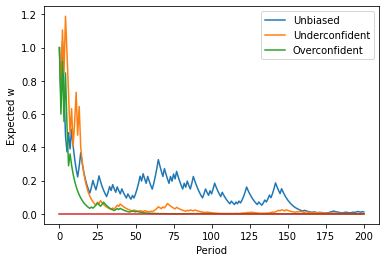

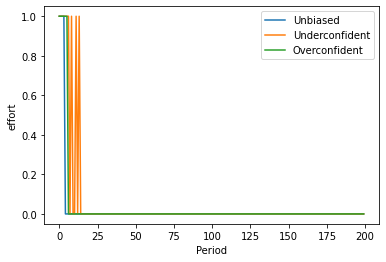

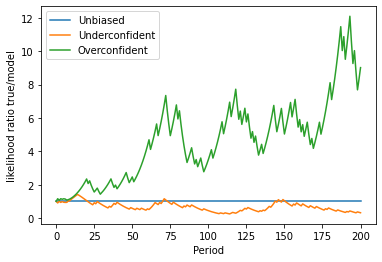

In [10]:
# set the true wage and the true type (index)
w_true = 0
type_true = 1
type_over = 2
type_under = 0

#prior
pi_0 = [1/3, 1/3, 1/3]

# save the outcome history
out_over = []
out_true = []
out_under = []

# save the posterior history (bayes on $\omega$ with fixed $\theta$)
pw_over = [pi_0]
pw_true = [pi_0]
pw_under = [pi_0]

# save the self-serving attribution posterior with distortion parameters $\gamma_w$ and $\gamma_t$
gamma_w = 2
gamma_t = 2

pw_selfs = [] 

#save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
p_over_model = []
p_under_model = []

p_over_true = []
p_under_true = []

# save the likelihood
likelihood_over = [1]
likelihood_under = [1]
likelihood_true = [1]

# save the effort history
e_over = []
e_true = []
e_under = []

# the starting beliefs for each type
p0_under = pi_0
p0_true = pi_0
p0_over = pi_0

# the expected value of $\omega$
Ew_over = [np.dot([0, 1, 2], pi_0)]
Ew_under = [np.dot([0, 1, 2], pi_0)]
Ew_true = [np.dot([0, 1, 2], pi_0)]

# the probability matices that we are using
M = [ML, MM, MH]

for i in range(200):
    #compute the expected success rate from every choice
    Eu_H = Eu(p0_over, 2, M)
    Eu_M = Eu(p0_true, 1, M)
    Eu_L = Eu(p0_under, 0, M)

    # save the effort that maximizes their success rate in the effort history vector
    choice_over = choice( Eu_H ) 
    choice_true = choice( Eu_M ) 
    choice_under = choice( Eu_L ) 

    # Draw a realization using the probability under the true type, for a given true $\omega$5
    outcome_over = np.random.binomial(1, MM[choice_over, w_true], size=None)
    outcome_true = np.random.binomial(1, MM[choice_true, w_true], size=None)
    outcome_under = np.random.binomial(1, MM[choice_under, w_true], size=None)

    # update the belief on omega given the outcome
    p1_over = bayesW(p0_over, choice_over, outcome_over, M, type_over)
    p1_under = bayesW(p0_under, choice_under, outcome_under, M, type_under)
    p1_true = bayesW(p0_true, choice_true, outcome_true, M, type_true )
    
        # compute the likelihood ratio of the true type over their believed type.
    # First save all the probabilities of the realized types
    if outcome_over == 1:
        p_over_model.append(M[type_over][choice_over, :])
        p_over_true.append(M[type_true][choice_over, :])
        
    else:
        p_over_model.append(1 - M[type_over][choice_over, :])
        p_over_true.append(1 - M[type_true][choice_over, :])
    
    if outcome_under == 1:
        p_under_model.append(M[type_under][choice_under, :])
        p_under_true.append(M[type_true][choice_under, :])
    else:
        p_under_model.append(1 - M[type_under][choice_under, :])
        p_under_true.append(1 - M[type_true][choice_under, :])
        
    # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
    likelihood_over.append(np.dot(np.prod(np.array(p_over_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_over_model), axis=0), pi_0))
    likelihood_under.append(np.dot(np.prod(np.array(p_under_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_under_model), axis=0), pi_0))
    likelihood_true.append(1)
    
    
    # their expectation of $\omega$ each period
    Ew_over.append(np.dot([0, 1, 2], p1_over))
    Ew_under.append(np.dot([0, 1, 2], p1_under))
    Ew_true.append(np.dot([0, 1, 2], p1_true))
    
    # add to the history vector of outcomes
    out_over.append( outcome_over )
    out_true.append( outcome_true )
    out_under.append( outcome_under )
    
    # add to the history of beliefs and update the prior
    # save the effort that maximizes their success rate in the effort history vector
    e_over.append( choice_over )
    e_true.append( choice_true )
    e_under.append( choice_under )
    
    pw_over.append( p1_over )
    pw_true.append( p1_true )
    pw_under.append( p1_under )
    
    p0_over = p1_over
    p0_true = p1_true
    p0_under = p1_under
    
plt.plot(Ew_true, label = "Unbiased")
plt.plot(Ew_under, label = "Underconfident")
plt.plot(Ew_over, label = "Overconfident")
plt.plot(w_true*np.ones(len(Ew_over)))

plt.xlabel("Period")
plt.ylabel("Expected w")
plt.legend()
plt.show()  

plt.plot(e_true, label = "Unbiased")
plt.plot(e_under, label = "Underconfident")
plt.plot(e_over, label = "Overconfident")
#plt.plot(w_true*np.ones(len(Ew_over)))

plt.xlabel("Period")
plt.ylabel("effort")
plt.legend()
plt.show()

plt.plot(likelihood_true, label = "Unbiased")
plt.plot(likelihood_under, label = "Underconfident")
plt.plot(likelihood_over, label = "Overconfident")
#plt.plot(w_true*np.ones(len(Ew_over)))

plt.xlabel("Period")
plt.ylabel("likelihood ratio true/model")
plt.legend()
plt.show()

## Single Agent Simulation For $\omega_M$

Now I can simuate the process. I will start with the over confident agent. The true type is $\theta^* = \theta_M$ but the agent thinks he is of type $\theta_H$. The true exchange rate is $\omega_M$ but the agent doesn't know this and assigns equal probability to each possible value. Upon choosing an effort, the agent observes a success or a failure and updates the belief about $\omega$ in a bayesian way. The belief about $\theta$ is never updated but we will track the likelihood for each possible $\theta$

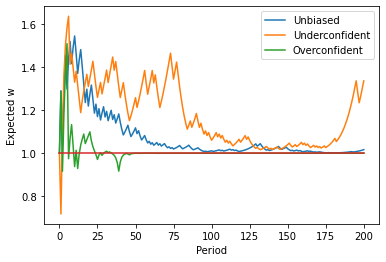

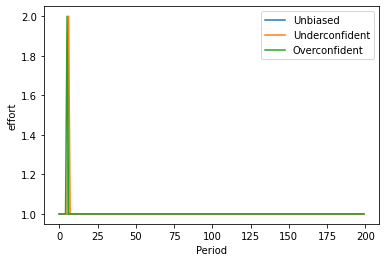

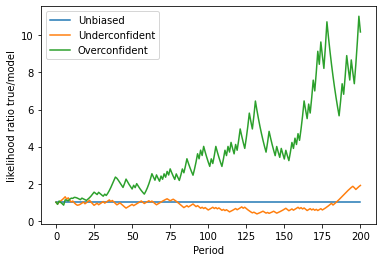

In [11]:
# set the true wage and the true type (index)
w_true = 1
type_true = 1
type_over = 2
type_under = 0

#prior
pi_0 = [1/3, 1/3, 1/3]

# save the outcome history
out_over = []
out_true = []
out_under = []

# save the posterior history (bayes on $\omega$ with fixed $\theta$)
pw_over = [pi_0]
pw_true = [pi_0]
pw_under = [pi_0]

# save the self-serving attribution posterior with distortion parameters $\gamma_w$ and $\gamma_t$
gamma_w = 2
gamma_t = 2

pw_selfs = [] 

#save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
p_over_model = []
p_under_model = []

p_over_true = []
p_under_true = []

# save the likelihood
likelihood_over = [1]
likelihood_under = [1]
likelihood_true = [1]

# save the effort history
e_over = []
e_true = []
e_under = []

# the starting beliefs for each type
p0_under = pi_0
p0_true = pi_0
p0_over = pi_0

# the expected value of $\omega$
Ew_over = [np.dot([0, 1, 2], pi_0)]
Ew_under = [np.dot([0, 1, 2], pi_0)]
Ew_true = [np.dot([0, 1, 2], pi_0)]

# the probability matices that we are using
M = [ML, MM, MH]

for i in range(200):
    #compute the expected success rate from every choice
    Eu_H = Eu(p0_over, 2, M)
    Eu_M = Eu(p0_true, 1, M)
    Eu_L = Eu(p0_under, 0, M)

    # save the effort that maximizes their success rate in the effort history vector
    choice_over = choice( Eu_H ) 
    choice_true = choice( Eu_M ) 
    choice_under = choice( Eu_L ) 

    # Draw a realization using the probability under the true type, for a given true $\omega$5
    outcome_over = np.random.binomial(1, MM[choice_over, w_true], size=None)
    outcome_true = np.random.binomial(1, MM[choice_true, w_true], size=None)
    outcome_under = np.random.binomial(1, MM[choice_under, w_true], size=None)

    # update the belief on omega given the outcome
    p1_over = bayesW(p0_over, choice_over, outcome_over, M, type_over)
    p1_under = bayesW(p0_under, choice_under, outcome_under, M, type_under)
    p1_true = bayesW(p0_true, choice_true, outcome_true, M, type_true )
    
    # compute the likelihood ratio of the true type over their believed type.
    # First save all the probabilities of the realized types
    if outcome_over == 1:
        p_over_model.append(M[type_over][choice_over, :])
        p_over_true.append(M[type_true][choice_over, :])
        
    else:
        p_over_model.append(1 - M[type_over][choice_over, :])
        p_over_true.append(1 - M[type_true][choice_over, :])
    
    if outcome_under == 1:
        p_under_model.append(M[type_under][choice_under, :])
        p_under_true.append(M[type_true][choice_under, :])
    else:
        p_under_model.append(1 - M[type_under][choice_under, :])
        p_under_true.append(1 - M[type_true][choice_under, :])
        
    # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
    likelihood_over.append(np.dot(np.prod(np.array(p_over_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_over_model), axis=0), pi_0))
    likelihood_under.append(np.dot(np.prod(np.array(p_under_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_under_model), axis=0), pi_0))
    likelihood_true.append(1)
    
    
    # their expectation of $\omega$ each period
    Ew_over.append(np.dot([0, 1, 2], p1_over))
    Ew_under.append(np.dot([0, 1, 2], p1_under))
    Ew_true.append(np.dot([0, 1, 2], p1_true))
    
    # add to the history vector of outcomes
    out_over.append( outcome_over )
    out_true.append( outcome_true )
    out_under.append( outcome_under )
    
    # add to the history of beliefs and update the prior
    # save the effort that maximizes their success rate in the effort history vector
    e_over.append( choice_over )
    e_true.append( choice_true )
    e_under.append( choice_under )
    
    pw_over.append( p1_over )
    pw_true.append( p1_true )
    pw_under.append( p1_under )
    
    p0_over = p1_over
    p0_true = p1_true
    p0_under = p1_under
    
plt.plot(Ew_true, label = "Unbiased")
plt.plot(Ew_under, label = "Underconfident")
plt.plot(Ew_over, label = "Overconfident")
plt.plot(w_true*np.ones(len(Ew_over)))

plt.xlabel("Period")
plt.ylabel("Expected w")
plt.legend()
plt.show()  

plt.plot(e_true, label = "Unbiased")
plt.plot(e_under, label = "Underconfident")
plt.plot(e_over, label = "Overconfident")
#plt.plot(w_true*np.ones(len(Ew_over)))

plt.xlabel("Period")
plt.ylabel("effort")
plt.legend()
plt.show()

plt.plot(likelihood_true, label = "Unbiased")
plt.plot(likelihood_under, label = "Underconfident")
plt.plot(likelihood_over, label = "Overconfident")

plt.xlabel("Period")
plt.ylabel("likelihood ratio true/model")
plt.legend()
plt.show()

## Single Agent Simulation For $\omega_H$

Now I can simuate the process. I will start with the over confident agent. The true type is $\theta^* = \theta_M$ but the agent thinks he is of type $\theta_H$. The true exchange rate is $\omega_H$ but the agent doesn't know this and assigns equal probability to each possible value. Upon choosing an effort, the agent observes a success or a failure and updates the belief about $\omega$ in a bayesian way. The belief about $\theta$ is never updated but we will track the likelihood for each possible $\theta$

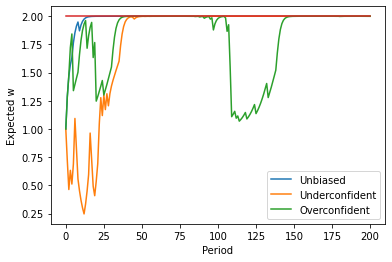

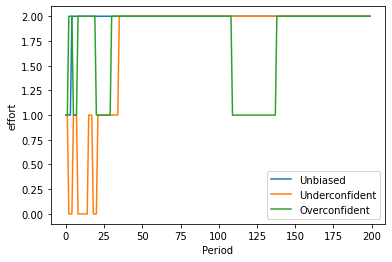

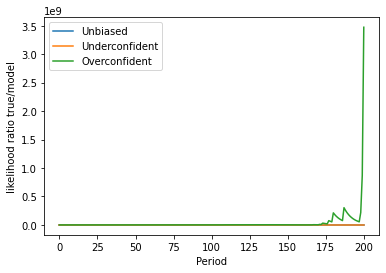

In [12]:
# set the true wage and the true type (index)
w_true = 2
type_true = 1
type_over = 2
type_under = 0

#prior
pi_0 = [1/3, 1/3, 1/3]

# save the outcome history
out_over = []
out_true = []
out_under = []

# save the posterior history (bayes on $\omega$ with fixed $\theta$)
pw_over = [pi_0]
pw_true = [pi_0]
pw_under = [pi_0]

# save the self-serving attribution posterior with distortion parameters $\gamma_w$ and $\gamma_t$
gamma_w = 2
gamma_t = 2

pw_selfs = [] 

#save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
p_over_model = []
p_under_model = []

p_over_true = []
p_under_true = []

# save the likelihood
likelihood_over = [1]
likelihood_under = [1]
likelihood_true =[1]

# save the effort history
e_over = []
e_true = []
e_under = []

# the starting beliefs for each type
p0_under = pi_0
p0_true = pi_0
p0_over = pi_0

# the expected value of $\omega$
Ew_over = [np.dot([0, 1, 2], pi_0)]
Ew_under = [np.dot([0, 1, 2], pi_0)]
Ew_true = [np.dot([0, 1, 2], pi_0)]

# the probability matices that we are using
M = [ML, MM, MH]

for i in range(200):
    #compute the expected success rate from every choice
    Eu_H = Eu(p0_over, 2, M)
    Eu_M = Eu(p0_true, 1, M)
    Eu_L = Eu(p0_under, 0, M)

    # save the effort that maximizes their success rate in the effort history vector
    choice_over = choice( Eu_H ) 
    choice_true = choice( Eu_M ) 
    choice_under = choice( Eu_L ) 

    # Draw a realization using the probability under the true type, for a given true $\omega$5
    outcome_over = np.random.binomial(1, MM[choice_over, w_true], size=None)
    outcome_true = np.random.binomial(1, MM[choice_true, w_true], size=None)
    outcome_under = np.random.binomial(1, MM[choice_under, w_true], size=None)

    # update the belief on omega given the outcome
    p1_over = bayesW(p0_over, choice_over, outcome_over, M, type_over)
    p1_under = bayesW(p0_under, choice_under, outcome_under, M, type_under)
    p1_true = bayesW(p0_true, choice_true, outcome_true, M, type_true )
    
    # compute the likelihood ratio of the true type over their believed type.
    # First save all the probabilities of the realized types
    if outcome_over == 1:
        p_over_model.append(M[type_over][choice_over, :])
        p_over_true.append(M[type_true][choice_over, :])
        
    else:
        p_over_model.append(1 - M[type_over][choice_over, :])
        p_over_true.append(1 - M[type_true][choice_over, :])
    
    if outcome_under == 1:
        p_under_model.append(M[type_under][choice_under, :])
        p_under_true.append(M[type_true][choice_under, :])
    else:
        p_under_model.append(1 - M[type_under][choice_under, :])
        p_under_true.append(1 - M[type_true][choice_under, :])
    
        
    # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
    likelihood_over.append(np.dot(np.prod(np.array(p_over_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_over_model), axis=0), pi_0))
    likelihood_under.append(np.dot(np.prod(np.array(p_under_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_under_model), axis=0), pi_0))
    likelihood_true.append(1)
    
    # their expectation of $\omega$ each period
    Ew_over.append(np.dot([0, 1, 2], p1_over))
    Ew_under.append(np.dot([0, 1, 2], p1_under))
    Ew_true.append(np.dot([0, 1, 2], p1_true))
    
    # add to the history vector of outcomes
    out_over.append( outcome_over )
    out_true.append( outcome_true )
    out_under.append( outcome_under )
    
    # add to the history of beliefs and update the prior
    # save the effort that maximizes their success rate in the effort history vector
    e_over.append( choice_over )
    e_true.append( choice_true )
    e_under.append( choice_under )
    
    pw_over.append( p1_over )
    pw_true.append( p1_true )
    pw_under.append( p1_under )
    
    p0_over = p1_over
    p0_true = p1_true
    p0_under = p1_under
    
plt.plot(Ew_true, label = "Unbiased")
plt.plot(Ew_under, label = "Underconfident")
plt.plot(Ew_over, label = "Overconfident")
plt.plot(w_true*np.ones(len(Ew_over)))

plt.xlabel("Period")
plt.ylabel("Expected w")
plt.legend()
plt.show()  

plt.plot(e_true, label = "Unbiased")
plt.plot(e_under, label = "Underconfident")
plt.plot(e_over, label = "Overconfident")
#plt.plot(w_true*np.ones(len(Ew_over)))
                
plt.xlabel("Period")
plt.ylabel("effort")
plt.legend()
plt.show()

plt.plot(likelihood_true, label = "Unbiased")
plt.plot(likelihood_under, label = "Underconfident")
plt.plot(likelihood_over, label = "Overconfident")


plt.xlabel("Period")
plt.ylabel("likelihood ratio true/model")
plt.legend()
plt.show()

## Multiple agents

Now I do the same for many agents and average their beliefs for each period.

### For $\omega_L$

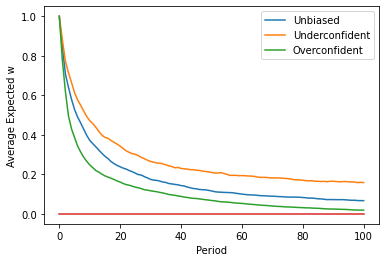

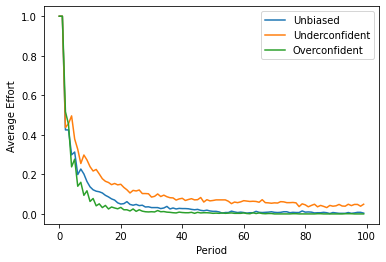

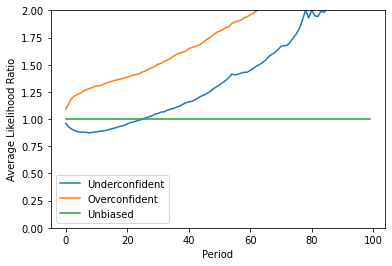

In [13]:
# n is the number of simulations, T is the number of periods
N = 1000
T = 100

# set the true wage and the true type (index)
w_true = 0
type_true = 1
type_over = 2
type_under = 0

#prior
pi_0 = [1/3, 1/3, 1/3]

pop_ew_over = []
pop_ew_under = []
pop_ew_true = []

pop_choices_over = []
pop_choices_under = []
pop_choices_true = []

pop_lr_over = []
pop_lr_under = []


for n in range(N):
    # save the outcome history
    out_over = []
    out_true = []
    out_under = []

    # save the posterior history (bayes on $\omega$ with fixed $\theta$)
    pw_over = []
    pw_true = []
    pw_under = []

    # save the self-serving attribution posterior with distortion parameters $\gamma_w$ and $\gamma_t$
    gamma_w = 2
    gamma_t = 2

    pw_selfs = [] 

    #save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
    p_over_model = []
    p_under_model = []

    p_over_true = []
    p_under_true = []

    # save the likelihood
    likelihood_over = []
    likelihood_under = []
    likelihood_true =[]

    # save the effort history
    e_over = []
    e_true = []
    e_under = []

    # the starting beliefs for each type
    p0_under = pi_0
    p0_true = pi_0
    p0_over = pi_0

    # the expected value of $\omega$
    Ew_over = [np.dot([0, 1, 2], pi_0)]
    Ew_under = [np.dot([0, 1, 2], pi_0)]
    Ew_true = [np.dot([0, 1, 2], pi_0)]

    # the probability matices that we are using
    M = [ML, MM, MH]

    for i in range(T):
        #compute the expected success rate from every choice
        Eu_H = Eu(p0_over, 2, M)
        Eu_M = Eu(p0_true, 1, M)
        Eu_L = Eu(p0_under, 0, M)

        # save the effort that maximizes their success rate in the effort history vector
        choice_over = choice( Eu_H ) 
        choice_true = choice( Eu_M ) 
        choice_under = choice( Eu_L ) 

        # Draw a realization using the probability under the true type, for a given true $\omega$5
        outcome_over = np.random.binomial(1, MM[choice_over, w_true], size=None)
        outcome_true = np.random.binomial(1, MM[choice_true, w_true], size=None)
        outcome_under = np.random.binomial(1, MM[choice_under, w_true], size=None)

        # update the belief on omega given the outcome
        p1_over = bayesW(p0_over, choice_over, outcome_over, M, type_over)
        p1_under = bayesW(p0_under, choice_under, outcome_under, M, type_under)
        p1_true = bayesW(p0_true, choice_true, outcome_true, M, type_true )

        # compute the likelihood ratio of the true type over their believed type.
        # First save all the probabilities of the realized types
        if outcome_over == 1:
            p_over_model.append(M[type_over][choice_over, :])
            p_over_true.append(M[type_true][choice_over, :])

        else:
            p_over_model.append(1 - M[type_over][choice_over, :])
            p_over_true.append(1 - M[type_true][choice_over, :])

        if outcome_under == 1:
            p_under_model.append(M[type_under][choice_under, :])
            p_under_true.append(M[type_true][choice_under, :])
        else:
            p_under_model.append(1 - M[type_under][choice_under, :])
            p_under_true.append(1 - M[type_true][choice_under, :])


        # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
        likelihood_over.append(np.dot(np.prod(np.array(p_over_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_over_model), axis=0), pi_0))
        likelihood_under.append(np.dot(np.prod(np.array(p_under_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_under_model), axis=0), pi_0))
        likelihood_true.append(1)

        # their expectation of $\omega$ each period
        Ew_over.append(np.dot([0, 1, 2], p1_over))
        Ew_under.append(np.dot([0, 1, 2], p1_under))
        Ew_true.append(np.dot([0, 1, 2], p1_true))

        # add to the history vector of outcomes
        out_over.append( outcome_over )
        out_true.append( outcome_true )
        out_under.append( outcome_under )

        # add to the history of beliefs and update the prior
        # save the effort that maximizes their success rate in the effort history vector
        e_over.append( choice_over )
        e_true.append( choice_true )
        e_under.append( choice_under )

        pw_over.append( p1_over )
        pw_true.append( p1_true )
        pw_under.append( p1_under )

        p0_over = p1_over
        p0_true = p1_true
        p0_under = p1_under
    
    pop_ew_over.append(Ew_over)
    pop_ew_under.append(Ew_under)
    pop_ew_true.append(Ew_true)
    
    pop_choices_over.append(e_over)
    pop_choices_under.append(e_under)
    pop_choices_true.append(e_true)

    pop_lr_over.append( likelihood_over )
    pop_lr_under.append( likelihood_under)

    
plt.plot(np.mean(pop_ew_true, axis=0), label = "Unbiased")
plt.plot(np.mean(pop_ew_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_ew_over, axis=0), label = "Overconfident")
plt.plot(w_true*np.ones(len(np.mean(pop_ew_true, axis=0))))

plt.xlabel("Period")
plt.ylabel("Average Expected w")
plt.legend()
plt.show()  

plt.plot(np.mean(pop_choices_true, axis=0), label = "Unbiased")
plt.plot(np.mean(pop_choices_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_choices_over, axis=0), label = "Overconfident")

                
plt.xlabel("Period")
plt.ylabel("Average Effort")
plt.legend()
plt.show()

plt.plot(np.mean(pop_lr_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_lr_over, axis=0), label = "Overconfident")
plt.plot(np.ones(len(np.mean(pop_lr_over, axis=0))), label="Unbiased")

plt.xlabel("Period")
plt.ylim([0, 2])
plt.ylabel("Average Likelihood Ratio")
plt.legend()
plt.show()




In [14]:
#pop_ew_under
#pop_ew_true
    
#pop_choices_over
#pop_choices_under
#pop_choices_true

#pop_lr_over
#pop_lr_under

### For $\omega_M$

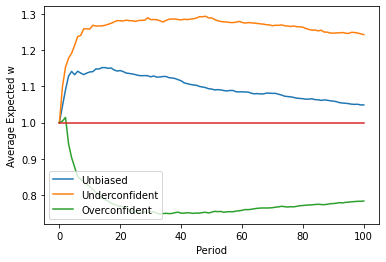

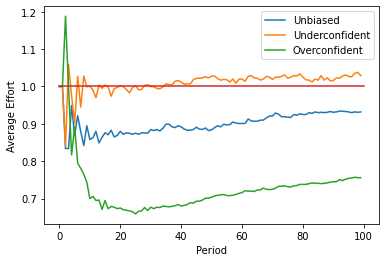

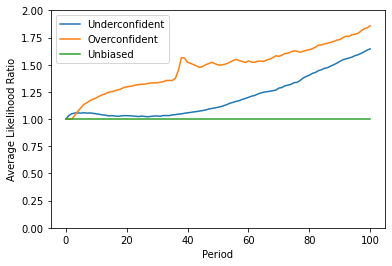

In [15]:
# n is the number of simulations, T is the number of periods
N = 1000
T = 100

# set the true wage and the true type (index)
w_true = 1
type_true = 1
type_over = 2
type_under = 0

#prior
pi_0 = [1/3, 1/3, 1/3]

pop_ew_over = []
pop_ew_under = []
pop_ew_true = []

pop_choices_over = []
pop_choices_under = []
pop_choices_true = []

pop_lr_over = []
pop_lr_under = []


for n in range(N):
    # save the outcome history
    out_over = []
    out_true = []
    out_under = []

    # save the posterior history (bayes on $\omega$ with fixed $\theta$)
    pw_over = [pi_0]
    pw_true = [pi_0]
    pw_under = [pi_0]

    # save the self-serving attribution posterior with distortion parameters $\gamma_w$ and $\gamma_t$
    gamma_w = 2
    gamma_t = 2

    pw_selfs = [] 

    #save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
    p_over_model = []
    p_under_model = []

    p_over_true = []
    p_under_true = []

    # save the likelihood
    likelihood_over = [1]
    likelihood_under = [1]
    likelihood_true =[1]

    # save the effort history
    e_over = []
    e_true = []
    e_under = []

    # the starting beliefs for each type
    p0_under = pi_0
    p0_true = pi_0
    p0_over = pi_0

    # the expected value of $\omega$
    Ew_over = [np.dot([0, 1, 2], pi_0)]
    Ew_under = [np.dot([0, 1, 2], pi_0)]
    Ew_true = [np.dot([0, 1, 2], pi_0)]

    # the probability matices that we are using
    M = [ML, MM, MH]

    for i in range(T):
        #compute the expected success rate from every choice
        Eu_H = Eu(p0_over, 2, M)
        Eu_M = Eu(p0_true, 1, M)
        Eu_L = Eu(p0_under, 0, M)

        # save the effort that maximizes their success rate in the effort history vector
        choice_over = choice( Eu_H ) 
        choice_true = choice( Eu_M ) 
        choice_under = choice( Eu_L ) 

        # Draw a realization using the probability under the true type, for a given true $\omega$5
        outcome_over = np.random.binomial(1, MM[choice_over, w_true], size=None)
        outcome_true = np.random.binomial(1, MM[choice_true, w_true], size=None)
        outcome_under = np.random.binomial(1, MM[choice_under, w_true], size=None)

        # update the belief on omega given the outcome
        p1_over = bayesW(p0_over, choice_over, outcome_over, M, type_over)
        p1_under = bayesW(p0_under, choice_under, outcome_under, M, type_under)
        p1_true = bayesW(p0_true, choice_true, outcome_true, M, type_true )

        # compute the likelihood ratio of the true type over their believed type.
        # First save all the probabilities of the realized types
        if outcome_over == 1:
            p_over_model.append(M[type_over][choice_over, :])
            p_over_true.append(M[type_true][choice_over, :])

        else:
            p_over_model.append(1 - M[type_over][choice_over, :])
            p_over_true.append(1 - M[type_true][choice_over, :])

        if outcome_under == 1:
            p_under_model.append(M[type_under][choice_under, :])
            p_under_true.append(M[type_true][choice_under, :])
        else:
            p_under_model.append(1 - M[type_under][choice_under, :])
            p_under_true.append(1 - M[type_true][choice_under, :])


        # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
        likelihood_over.append(np.dot(np.prod(np.array(p_over_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_over_model), axis=0), pi_0))
        likelihood_under.append(np.dot(np.prod(np.array(p_under_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_under_model), axis=0), pi_0))
        likelihood_true.append(1)

        # their expectation of $\omega$ each period
        Ew_over.append(np.dot([0, 1, 2], p1_over))
        Ew_under.append(np.dot([0, 1, 2], p1_under))
        Ew_true.append(np.dot([0, 1, 2], p1_true))

        # add to the history vector of outcomes
        out_over.append( outcome_over )
        out_true.append( outcome_true )
        out_under.append( outcome_under )

        # add to the history of beliefs and update the prior
        # save the effort that maximizes their success rate in the effort history vector
        e_over.append( choice_over )
        e_true.append( choice_true )
        e_under.append( choice_under )

        pw_over.append( p1_over )
        pw_true.append( p1_true )
        pw_under.append( p1_under )

        p0_over = p1_over
        p0_true = p1_true
        p0_under = p1_under
    
    pop_ew_over.append(Ew_over)
    pop_ew_under.append(Ew_under)
    pop_ew_true.append(Ew_true)
    
    pop_choices_over.append(e_over)
    pop_choices_under.append(e_under)
    pop_choices_true.append(e_true)

    pop_lr_over.append( likelihood_over )
    pop_lr_under.append( likelihood_under)

    
plt.plot(np.mean(pop_ew_true, axis=0), label = "Unbiased")
plt.plot(np.mean(pop_ew_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_ew_over, axis=0), label = "Overconfident")
plt.plot(w_true*np.ones(len(np.mean(pop_ew_true, axis=0))))

plt.xlabel("Period")
plt.ylabel("Average Expected w")
plt.legend()
plt.show()  

plt.plot(np.mean(pop_choices_true, axis=0), label = "Unbiased")
plt.plot(np.mean(pop_choices_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_choices_over, axis=0), label = "Overconfident")
plt.plot(w_true*np.ones(len(np.mean(pop_ew_true, axis=0))))

                
plt.xlabel("Period")
plt.ylabel("Average Effort")
plt.legend()
plt.show()

plt.plot(np.mean(pop_lr_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_lr_over, axis=0), label = "Overconfident")
plt.plot(np.ones(len(np.mean(pop_lr_over, axis=0))), label="Unbiased")

plt.xlabel("Period")
plt.ylim([0, 2])
plt.ylabel("Average Likelihood Ratio")
plt.legend()
plt.show()

    
    
    

### For $\omega_H$

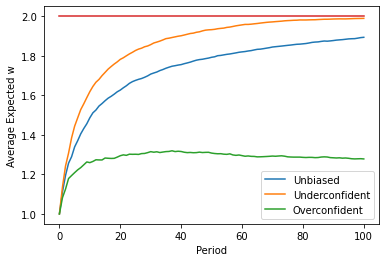

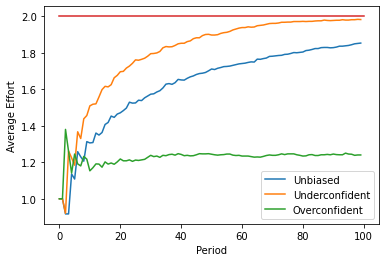

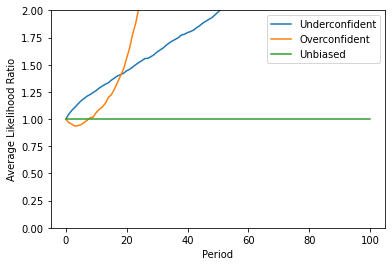

In [16]:
# n is the number of simulations, T is the number of periods
N = 1000
T = 100

# set the true wage and the true type (index)
w_true = 2
type_true = 1
type_over = 2
type_under = 0

#prior
pi_0 = [1/3, 1/3, 1/3]

pop_ew_over = []
pop_ew_under = []
pop_ew_true = []

pop_choices_over = []
pop_choices_under = []
pop_choices_true = []

pop_lr_over = []
pop_lr_under = []


for n in range(N):
    # save the outcome history
    out_over = []
    out_true = []
    out_under = []

    # save the posterior history (bayes on $\omega$ with fixed $\theta$)
    pw_over = [pi_0]
    pw_true = [pi_0]
    pw_under = [pi_0]

    # save the self-serving attribution posterior with distortion parameters $\gamma_w$ and $\gamma_t$
    gamma_w = 2
    gamma_t = 2

    pw_selfs = [] 

    #save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
    p_over_model = []
    p_under_model = []

    p_over_true = []
    p_under_true = []

    # save the likelihood
    likelihood_over = [1]
    likelihood_under = [1]
    likelihood_true =[1]

    # save the effort history
    e_over = []
    e_true = []
    e_under = []

    # the starting beliefs for each type
    p0_under = pi_0
    p0_true = pi_0
    p0_over = pi_0

    # the expected value of $\omega$
    Ew_over = [np.dot([0, 1, 2], pi_0)]
    Ew_under = [np.dot([0, 1, 2], pi_0)]
    Ew_true = [np.dot([0, 1, 2], pi_0)]

    # the probability matices that we are using
    M = [ML, MM, MH]

    for i in range(T):
        #compute the expected success rate from every choice
        Eu_H = Eu(p0_over, 2, M)
        Eu_M = Eu(p0_true, 1, M)
        Eu_L = Eu(p0_under, 0, M)

        # save the effort that maximizes their success rate in the effort history vector
        choice_over = choice( Eu_H ) 
        choice_true = choice( Eu_M ) 
        choice_under = choice( Eu_L ) 

        # Draw a realization using the probability under the true type, for a given true $\omega$5
        outcome_over = np.random.binomial(1, MM[choice_over, w_true], size=None)
        outcome_true = np.random.binomial(1, MM[choice_true, w_true], size=None)
        outcome_under = np.random.binomial(1, MM[choice_under, w_true], size=None)

        # update the belief on omega given the outcome
        p1_over = bayesW(p0_over, choice_over, outcome_over, M, type_over)
        p1_under = bayesW(p0_under, choice_under, outcome_under, M, type_under)
        p1_true = bayesW(p0_true, choice_true, outcome_true, M, type_true )

        # compute the likelihood ratio of the true type over their believed type.
        # First save all the probabilities of the realized types
        if outcome_over == 1:
            p_over_model.append(M[type_over][choice_over, :])
            p_over_true.append(M[type_true][choice_over, :])

        else:
            p_over_model.append(1 - M[type_over][choice_over, :])
            p_over_true.append(1 - M[type_true][choice_over, :])

        if outcome_under == 1:
            p_under_model.append(M[type_under][choice_under, :])
            p_under_true.append(M[type_true][choice_under, :])
        else:
            p_under_model.append(1 - M[type_under][choice_under, :])
            p_under_true.append(1 - M[type_true][choice_under, :])


        # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
        likelihood_over.append(np.dot(np.prod(np.array(p_over_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_over_model), axis=0), pi_0))
        likelihood_under.append(np.dot(np.prod(np.array(p_under_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_under_model), axis=0), pi_0))
        likelihood_true.append(1)

        # their expectation of $\omega$ each period
        Ew_over.append(np.dot([0, 1, 2], p1_over))
        Ew_under.append(np.dot([0, 1, 2], p1_under))
        Ew_true.append(np.dot([0, 1, 2], p1_true))

        # add to the history vector of outcomes
        out_over.append( outcome_over )
        out_true.append( outcome_true )
        out_under.append( outcome_under )

        # add to the history of beliefs and update the prior
        # save the effort that maximizes their success rate in the effort history vector
        e_over.append( choice_over )
        e_true.append( choice_true )
        e_under.append( choice_under )

        pw_over.append( p1_over )
        pw_true.append( p1_true )
        pw_under.append( p1_under )

        p0_over = p1_over
        p0_true = p1_true
        p0_under = p1_under
    
    pop_ew_over.append(Ew_over)
    pop_ew_under.append(Ew_under)
    pop_ew_true.append(Ew_true)
    
    pop_choices_over.append(e_over)
    pop_choices_under.append(e_under)
    pop_choices_true.append(e_true)

    pop_lr_over.append( likelihood_over )
    pop_lr_under.append( likelihood_under)

    
plt.plot(np.mean(pop_ew_true, axis=0), label = "Unbiased")
plt.plot(np.mean(pop_ew_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_ew_over, axis=0), label = "Overconfident")
plt.plot(w_true*np.ones(len(np.mean(pop_ew_true, axis=0))))

plt.xlabel("Period")
plt.ylabel("Average Expected w")
plt.legend()
plt.show()  

plt.plot(np.mean(pop_choices_true, axis=0), label = "Unbiased")
plt.plot(np.mean(pop_choices_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_choices_over, axis=0), label = "Overconfident")
plt.plot(w_true*np.ones(len(np.mean(pop_ew_true, axis=0))))

                
plt.xlabel("Period")
plt.ylabel("Average Effort")
plt.legend()
plt.show()

plt.plot(np.mean(pop_lr_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_lr_over, axis=0), label = "Overconfident")
plt.plot(np.ones(len(np.mean(pop_lr_over, axis=0))), label="Unbiased")

plt.xlabel("Period")
plt.ylim([0, 2])
plt.ylabel("Average Likelihood Ratio")
plt.legend()
plt.show()


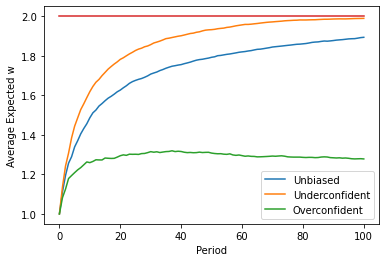

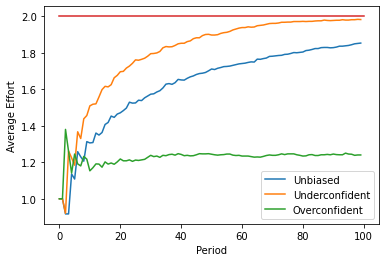

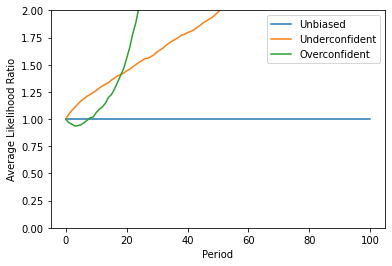

In [17]:
plt.plot(np.mean(pop_ew_true, axis=0), label = "Unbiased")
plt.plot(np.mean(pop_ew_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_ew_over, axis=0), label = "Overconfident")
plt.plot(w_true*np.ones(len(np.mean(pop_ew_true, axis=0))))

plt.xlabel("Period")
plt.ylabel("Average Expected w")
plt.legend()
plt.show()  

plt.plot(np.mean(pop_choices_true, axis=0), label = "Unbiased")
plt.plot(np.mean(pop_choices_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_choices_over, axis=0), label = "Overconfident")
plt.plot(w_true*np.ones(len(np.mean(pop_ew_true, axis=0))))

                
plt.xlabel("Period")
plt.ylabel("Average Effort")
plt.legend()
plt.show()

plt.plot(np.ones(len(np.mean(pop_lr_over, axis=0))), label="Unbiased")
plt.plot(np.mean(pop_lr_under, axis=0), label = "Underconfident")
plt.plot(np.mean(pop_lr_over, axis=0), label = "Overconfident")


plt.xlabel("Period")
plt.ylim([0, 2])
plt.ylabel("Average Likelihood Ratio")
plt.legend()
plt.show()

Check how many of each type get trapped choosing the wrog thing at period 100. Plot the distribution of choices at that period.